In [3]:
%load_ext autoreload
%autoreload 2

# Training

In this notebook we show the overall workflow to train a superresolution model. A standalone training script is provided in `train.py`.

## Data

Our dataset is formed of pairs of High-Resolution and Low-Resolution images. In this case, we have 384x384 Satellogic images and 384x384 matching Sentinel 2. Since the resolution of the Sentinel 2 is 10m and Satellogic is 1m, we center crop the HR images to 380x380 and the LR images to 38x38 so they match.

In [50]:
from src.dm import ESRTDatamodule

dm = ESRTDatamodule(
    path = "/fastdata/superres",
    upscale = 2,
    batch_size = 5,
    resize = False # only to see original hr images, for training always set to True
)

dm.setup()


Found 10761 images (removed 0 images)
Using 8609 training images and 2152 validation images


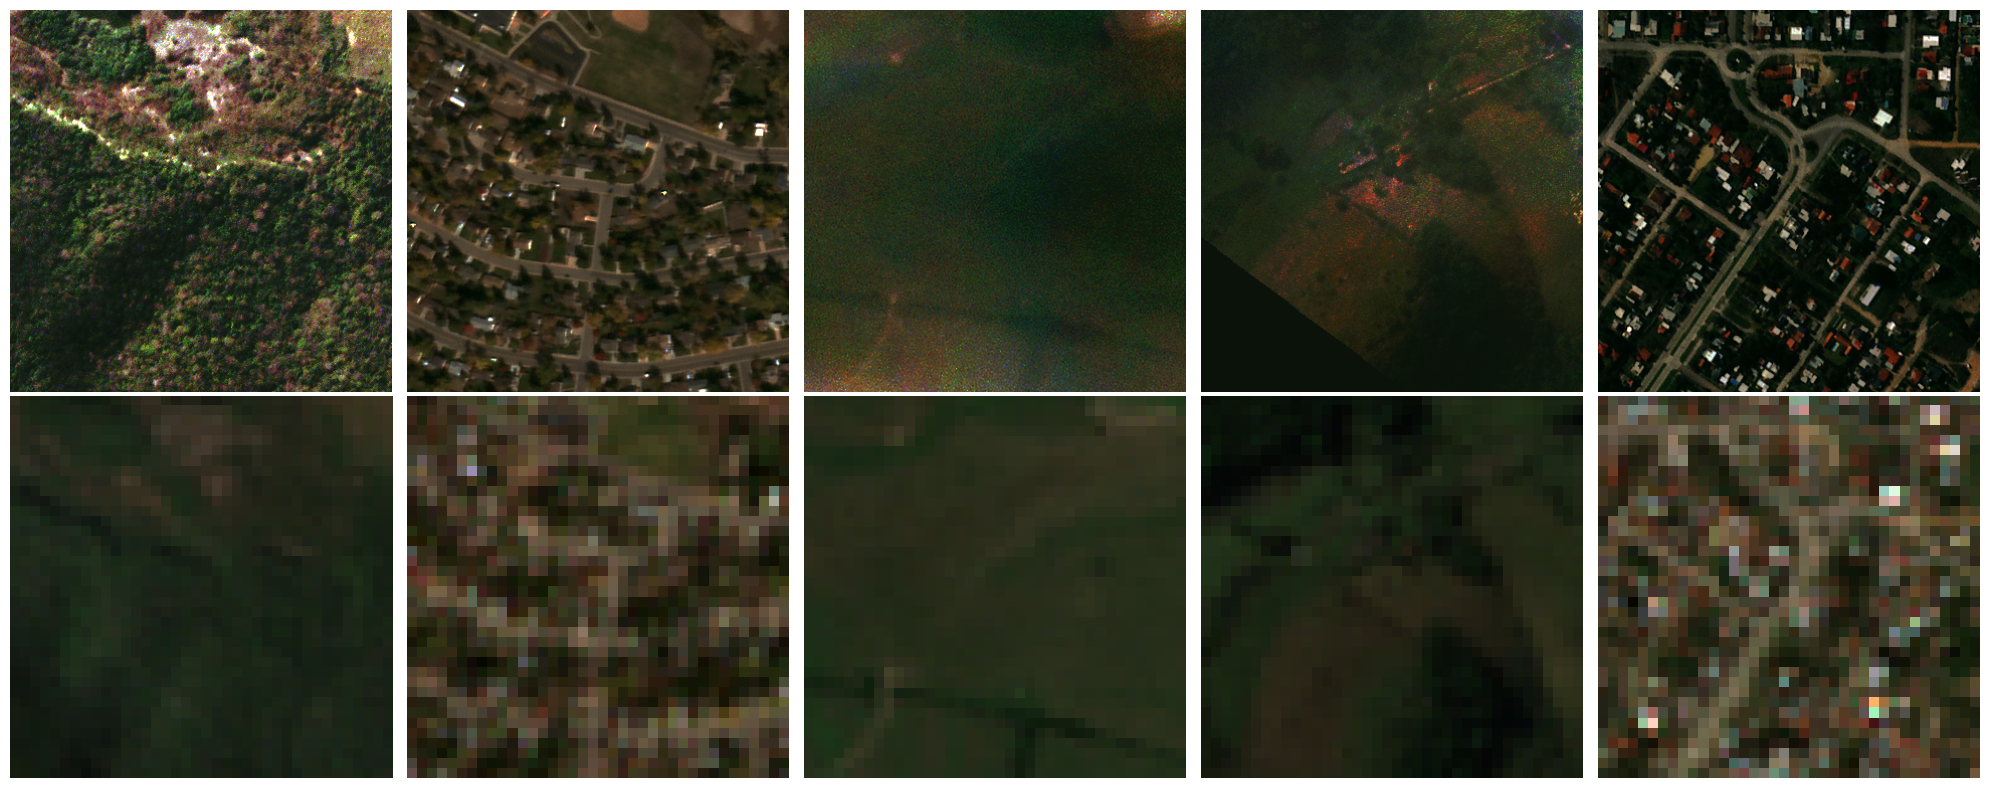

In [51]:
import matplotlib.pyplot as plt

batch = next(iter(dm.train_dataloader(shuffle=False)))
lr_images, hr_images = batch

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    hr_img = hr_images[i].permute(1, 2, 0).numpy()
    axes[0, i].imshow(hr_img[..., :3])
    axes[0, i].axis('off')
for i in range(5):
    lr_img = lr_images[i].permute(1, 2, 0).numpy()
    axes[1, i].imshow(lr_img[..., :3])
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [52]:
lr_images.shape, hr_images.shape

(torch.Size([5, 4, 38, 38]), torch.Size([5, 4, 380, 380]))

During training, we resize HR image to match the target upsacling factor.

In [53]:
dm = ESRTDatamodule(
    path = "/fastdata/superres",
    upscale = 2,
    batch_size = 5,
    resize = True # only to see original hr images, for training always set to True
)

dm.setup()

Found 10761 images (removed 0 images)
Using 8609 training images and 2152 validation images


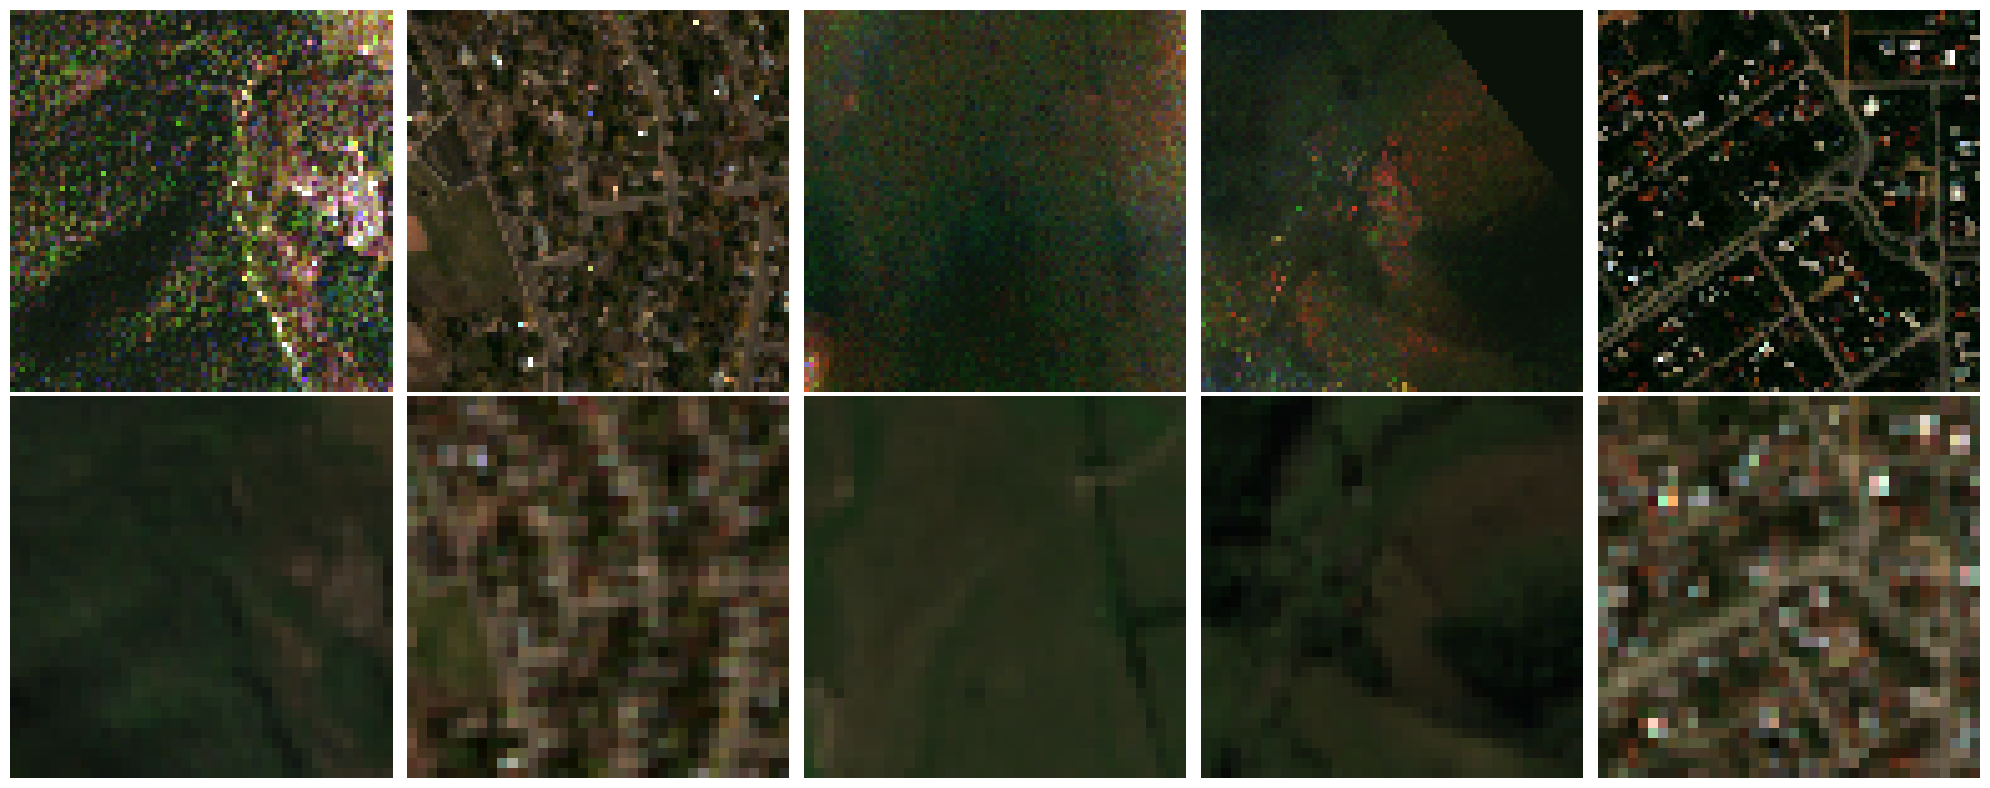

In [54]:
import matplotlib.pyplot as plt

batch = next(iter(dm.train_dataloader(shuffle=False)))
lr_images, hr_images = batch

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    hr_img = hr_images[i].permute(1, 2, 0).numpy()
    axes[0, i].imshow(hr_img[..., :3])
    axes[0, i].axis('off')
for i in range(5):
    lr_img = lr_images[i].permute(1, 2, 0).numpy()
    axes[1, i].imshow(lr_img[..., :3])
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Model

In [ ]:
from src.module import ESRTModule

module = ESRTModule(
    upscale=2,
)

output = module(lr_images)

output.shape, hr_images.shape

(torch.Size([5, 4, 76, 76]), torch.Size([5, 4, 76, 76]))

: 

## Training

For training, please use the `train.py` script.

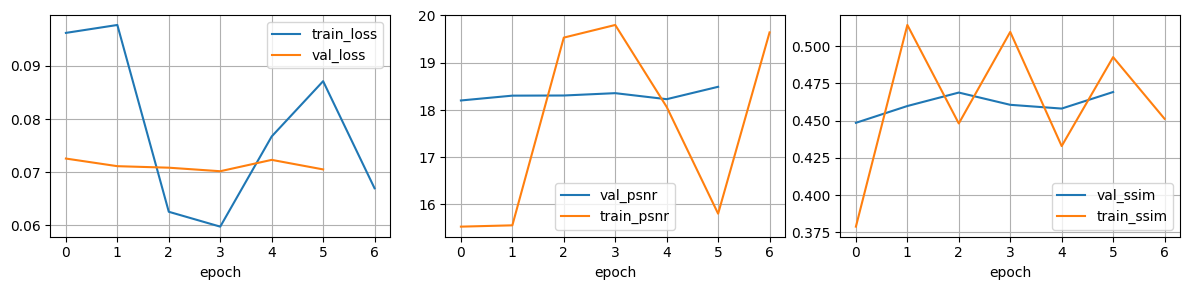

In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt

versions = sorted(os.listdir('logs/esrt_2x'))
last_version = versions[-1]

metrics = pd.read_csv(f'logs/esrt_2x/{last_version}/metrics.csv')
metrics = metrics.groupby('epoch').last().reset_index()

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
metrics.plot(x='epoch', y='train_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_psnr', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='train_psnr', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='val_ssim', kind='line', ax=axs[2], grid=True)
metrics.plot(x='epoch', y='train_ssim', kind='line', ax=axs[2], grid=True)
plt.tight_layout()
plt.show()